In [32]:
import pyarrow.parquet as pa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from category_encoders import BinaryEncoder
from sklearn.preprocessing import MinMaxScaler
import torch
#from tensorboardX import SummaryWriter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.cm as cm

In [72]:
import torch
import torch.nn as nn

class PCAAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, last_hidden_shape):
        super().__init__()
        self.encoder = nn.ModuleList(encoder)  # Ensure encoder is a ModuleList
        self.decoder = nn.ModuleList(decoder)  # Ensure decoder is a ModuleList
        self.last_hidden_shape = last_hidden_shape
        self.bottleneck = nn.ModuleList([nn.Linear(in_features=self.last_hidden_shape, out_features=1),
                                         nn.BatchNorm1d(num_features=1, affine=False)])

    def increase_latentdim(self):
        # Create new bottleneck expansion layer
        new_bottleneck = nn.ModuleList([nn.Linear(in_features=self.last_hidden_shape, out_features=self.bottleneck[0].out_features + 1),
                                        nn.BatchNorm1d(num_features=self.bottleneck[0].out_features + 1, affine=False)])
        # Copying weights while freezing old neurons
        with torch.no_grad():
            new_bottleneck[0].weight[: self.bottleneck[0].out_features] = self.bottleneck[0].weight
            new_bottleneck[0].bias[: self.bottleneck[0].out_features] = self.bottleneck[0].bias

        self.bottleneck = new_bottleneck  # Replace the layer
        self.bottleneck[0].requires_grad_(True)  # Allow gradients

        # Freeze the old neurons using a hook
        self.bottleneck[0].weight.register_hook(self._freeze_old_neurons_hook)
        self.bottleneck[0].bias.register_hook(self._freeze_old_neurons_hook)

        # Turn off gradients for all layers in the encoder (just in case)
        for layer in self.encoder:
            for param in layer.parameters():
                param.requires_grad = False

        self._recreate_decoder()

    def _freeze_old_neurons_hook(self, grad):
        """Backward hook: Freeze gradients for old neurons, allowing updates only for new ones"""
        grad[: -1] = 0  # Zero out gradients for old neurons
        return grad

    def _recreate_decoder(self):
        # Copying old decoder to new
        new_decoder = nn.ModuleList()
        for i, layer in enumerate(self.decoder):
            if i == 0 and isinstance(layer, nn.Linear):
                new_layer = nn.Linear(layer.in_features + 1, layer.out_features)
                nn.init.xavier_uniform_(new_layer.weight)
                if new_layer.bias is not None:
                    nn.init.zeros_(new_layer.bias)
                new_decoder.append(new_layer)
            else:
                new_decoder.append(layer)
        
        self.decoder = new_decoder  # Ensure it's still a ModuleList

    def encode(self, x):
        for layer in self.encoder:
            x = layer(x)
        for layer in self.bottleneck:
            x = layer(x)
        return x

    def decode(self, x):
        for layer in self.decoder:
            x = layer(x)
        return x  # Return the output

    def forward(self, x):
        enc = self.encode(x)
        out = self.decode(enc)
        return out, enc

In [85]:
class PCAAE_Loss(nn.Module):
    def __init__(self, loss_func, lambda_cov=0.01):
        super().__init__()
        self.loss_func = loss_func
        self.lambda_cov = lambda_cov

    
    def forward(self, y_hat, y, z):
        recon_loss = self.loss_func(y_hat, y)

        batch_size, latent_dim = z.shape
        z_mean = torch.mean(z, dim=0, keepdim=True)
        z_centered = z - z_mean

        covariance_matrix = (z_centered.T @ z_centered) / batch_size
        covariance_loss = torch.sum(covariance_matrix**2) - torch.sum(torch.diagonal(covariance_matrix)**2)

        total_loss = recon_loss + self.lambda_cov * covariance_loss
        return total_loss, recon_loss, covariance_loss

In [ ]:
def train_model(model, goal_hidden_dim, optimizer, loss_func, epochs, trainloader, testloader, print_every):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    outer_steps = 0
    total_steps = 0
    total_train_losses, total_test_losses = [], []
    if isinstance(loss_func, PCAAE_Loss):
        total_train_recon_losses, total_test_recon_losses = [], []
        total_train_cov_losses, total_test_cov_losses = [], []
    total_min_testloss = np.Inf
    hidden_dim = 1
    
    while hidden_dim != goal_hidden_dim:
        if not outer_steps == 0:
            # Increasing latent space
            model.increase_latentdim()
            hidden_dim += 1
            model.to(device)

        outer_steps += 1
        print(f"Training with hidden dim: {hidden_dim}")
        steps = 0
        train_losses, test_losses = [], []
        if isinstance(loss_func, PCAAE_Loss):
            train_recon_losses, test_recon_losses = [], []
            train_cov_losses, test_cov_losses = [], []
        min_test_loss = np.Inf

        # Training loop
        for e in range(epochs):
            running_loss = 0
            # Only for printing it
            running_loss_ = 0
            if isinstance(loss_func, PCAAE_Loss):
                running_recon_loss = 0
                running_cov_loss = 0
                running_recon_loss_ = 0
                running_cov_loss_ = 0

            for X, y in trainloader:
                steps += 1
                total_steps += 1
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                y_hat, hidden = model(X)
                if isinstance(loss_func, PCAAE_Loss):
                    loss, recon_loss, cov_loss = loss_func(y_hat, y, hidden)
                    running_recon_loss += recon_loss.item()*X.size(0)
                    running_cov_loss += cov_loss.item()*X.size(0)
                    running_recon_loss_ += recon_loss.item()
                    running_cov_loss_ += cov_loss.item()
                else:
                    loss = loss_func(y_hat, y)

                loss.backward()
                optimizer.step()
                running_loss += loss.item()*X.size(0)
                running_loss_ += loss.item()

                if steps % print_every == 0:
                    if isinstance(loss_func, PCAAE_Loss):
                        print(f"Epoch: {e + 1}/{epochs}, Step {steps}, Train loss: {running_loss_/print_every:.3f} " 
                              f"Train reconstruction loss: {running_recon_loss_/print_every:.3f} "
                              f"Train covariance loss: {running_cov_loss_/print_every:.3f}")
                    else:
                        print(f"Epoch: {e + 1}/{epochs}, Step {steps}, Train loss: {running_loss_/print_every:.3f}")
                    running_loss_ = 0
                    running_recon_loss_ = 0
                    running_cov_loss_ = 0

            # Running model on the test data  
            else:
                running_testloss = 0
                with torch.no_grad():
                    model.eval()
                    for X, y in testloader:
                        X, y = X.to(device), y.to(device)
                        y_hat, hidden = model(X)
                        test_loss = loss_func(y_hat, y, hidden) if isinstance(loss_func, PCAAE_Loss) else loss_func(y_hat, y)
                        running_testloss += test_loss.item()*X.size(0)
                model.train()

                train_losses.append(running_loss/len(trainloader.dataset))
                total_train_losses.append(running_loss/len(trainloader.dataset))
                test_losses.append(running_testloss/len(testloader.dataset))
                total_test_losses.append(running_testloss/len(testloader.dataset))

                # Saving model when test loss improved
                if test_losses[-1] <= min_test_loss:
                    print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_test_loss,test_losses[-1]))
                    torch.save(model.state_dict(), f'PCAAE_hidden_dim{hidden_dim}.pt')
                    min_test_loss = test_losses[-1]
                
                print(f'Epoch {e+1}/{epochs}, Train Loss: {running_loss/len(trainloader.dataset):.3f}, Test Loss: {running_testloss/len(testloader.dataset):.3f}')

    return total_train_losses, total_test_losses, total_steps              


In [74]:
# Dataset for tabular data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [75]:
# Loading data
inputFeature = pd.read_csv('../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
# Separating numerical and categorical features
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']
# Onehot-encoding categorical features
inputFeature_1h = pd.get_dummies(inputFeature, columns=categorical_features)

In [76]:
# Convert object columns to numeric if they represent categories
for column in inputFeature_1h.select_dtypes(include=['object']):
    inputFeature_1h[column] = inputFeature_1h[column].astype('category').cat.codes

# Train-test split
train, test = train_test_split(inputFeature_1h, test_size=0.1, random_state=42)

# Normalizing numerical features
for feature in numerical_features:
  train[feature] = (train[feature] - train[feature].min()) / (train[feature].max() - train[feature].min())
  test[feature] = (test[feature] - test[feature].min()) / (test[feature].max() - test[feature].min())

# Converting data to tensors
X_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))
y_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))

X_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))
y_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))

In [77]:
# Dataloaders
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [81]:
def covariance_loss(z):
    batch_size, latent_dim = z.shape
    z_mean = torch.mean(z, dim=0, keepdim=True)
    z_centered = z - z_mean

    cov_matrix = (z_centered.T @ z_centered) / batch_size
    cov_loss = torch.sum(cov_matrix**2) - torch.sum(torch.diagonal(cov_matrix)**2)
    return cov_loss

def complete_loss_func(y_hat, y, z, lambda_cov=0.01):
    loss = nn.MSELoss()
    reconstruction_loss = loss(y_hat, y)
    cov_loss = covariance_loss(z)
    total_loss = reconstruction_loss + lambda_cov * cov_loss
    return total_loss

In [82]:
# Define sizes for the layers
layer_sizes = [227, 64, 32]  # Example decreasing sizes for the encoder

# Create the encoder ModuleList
encoder = nn.ModuleList()
for i in range(len(layer_sizes) - 1):
    encoder.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
    encoder.append(nn.ReLU())

# Create the decoder ModuleList (mirror of the encoder)
decoder = nn.ModuleList()
decoder.append(nn.Linear(1, layer_sizes[len(layer_sizes) - 1]))
for i in range(len(layer_sizes) - 1, 0, -1):
    decoder.append(nn.Linear(layer_sizes[i], layer_sizes[i - 1]))
    decoder.append(nn.ReLU())

# Remove the last ReLU from the decoder (optional, depending on use case)
decoder = decoder[:-1]
criterion = complete_loss_func
model = PCAAutoencoder(encoder, decoder, 32)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25
print_every = 40

In [83]:
train_losses, test_losses, steps = train_model(model=model, goal_hidden_dim=5, 
                                         optimizer=optimizer, loss_func=criterion, epochs=epochs,
                                         trainloader=trainloader, testloader=testloader, print_every=40)

Training with hidden dim: 1
Epoch: 1/25, Step 40, Train loss: 0.044
Epoch: 1/25, Step 80, Train loss: 0.024
Epoch: 1/25, Step 120, Train loss: 0.023
Epoch: 1/25, Step 160, Train loss: 0.023
Epoch: 1/25, Step 200, Train loss: 0.023
Epoch: 1/25, Step 240, Train loss: 0.023
Epoch: 1/25, Step 280, Train loss: 0.023
Epoch: 1/25, Step 320, Train loss: 0.023
Epoch: 1/25, Step 360, Train loss: 0.023
Epoch: 1/25, Step 400, Train loss: 0.023
Epoch: 1/25, Step 440, Train loss: 0.023
Epoch: 1/25, Step 480, Train loss: 0.023
Test loss decreased (inf --> 0.022674).  Saving model ...
Epoch 1/25, Train Loss: 0.025, Test Loss: 0.023
Epoch: 2/25, Step 520, Train loss: 0.023
Epoch: 2/25, Step 560, Train loss: 0.023
Epoch: 2/25, Step 600, Train loss: 0.023
Epoch: 2/25, Step 640, Train loss: 0.023
Epoch: 2/25, Step 680, Train loss: 0.023
Epoch: 2/25, Step 720, Train loss: 0.023
Epoch: 2/25, Step 760, Train loss: 0.023
Epoch: 2/25, Step 800, Train loss: 0.023
Epoch: 2/25, Step 840, Train loss: 0.023
Epoch: 

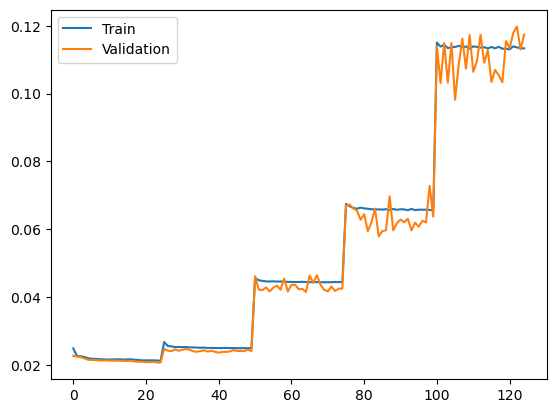

In [84]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend()
plt.show()

In [43]:
for layer in model.bottleneck:
    print(layer)

Linear(in_features=32, out_features=1, bias=True)
BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)


In [62]:
model.bottleneck[0].out_features

1